# This Looks Like That There

Main training notebook.

In [1]:
import os
import sys
import time
import imp #imp.reload(module)

import numpy as np
from tqdm import trange
from icecream import ic

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf

import network
import experiment_settings 
import data_functions
import push_prototypes
import plots
import common_functions

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "1 December 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
numpy version = 1.21.5
tensorflow version = 2.9.0


## Define experiment settings and directories

In [5]:
EXP_NAME = 'fourteenday_test' #'mjo_seed28'#'quadrants_testcase'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)

## Define the network parameters

In [6]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE_PREDICT   = settings['batch_size_predict']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs']
LR_INIT              = settings['lr']
LR_CALLBACK_EPOCH    = settings['lr_cb_epoch']
PATIENCE             = 100

## Initialize

In [7]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

(73000, 96, 161, 1)


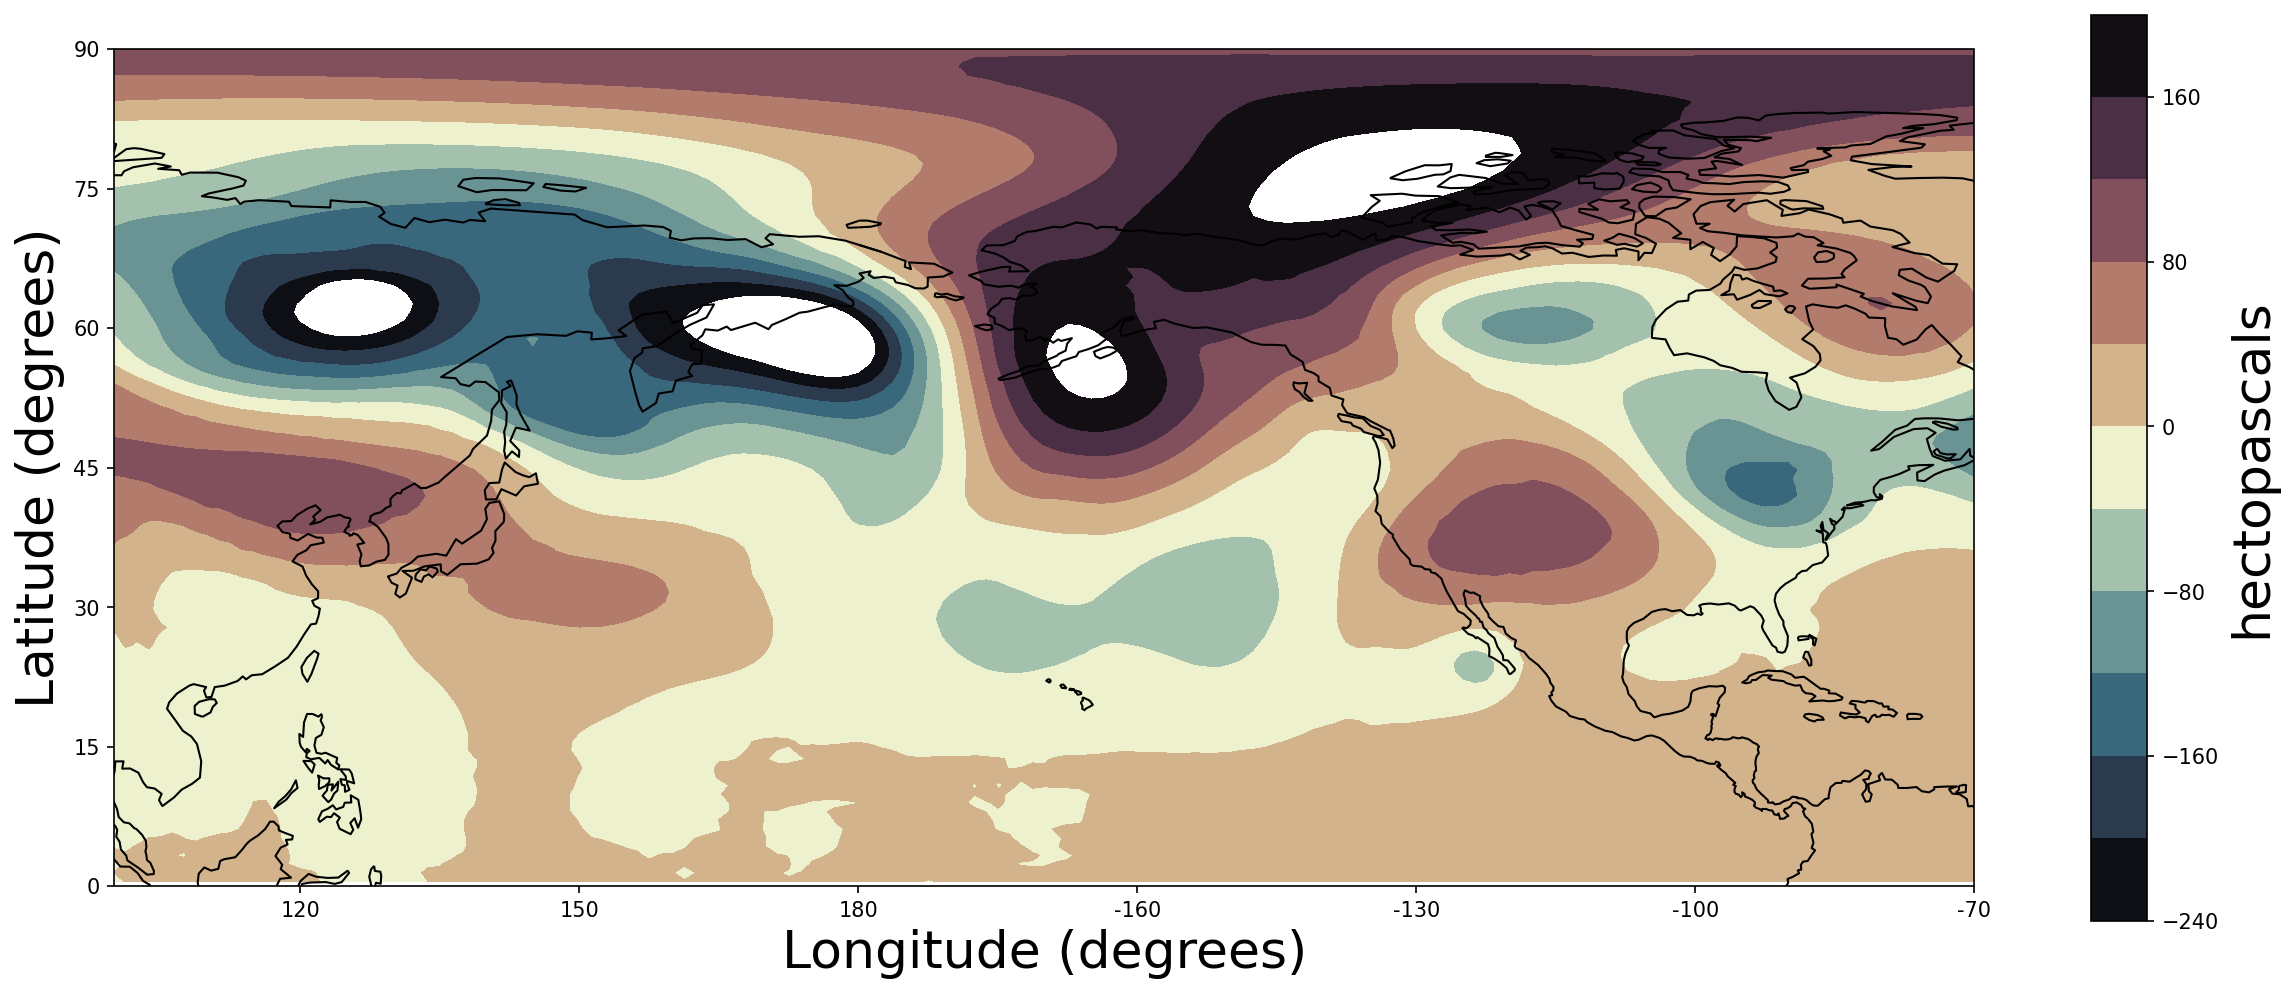

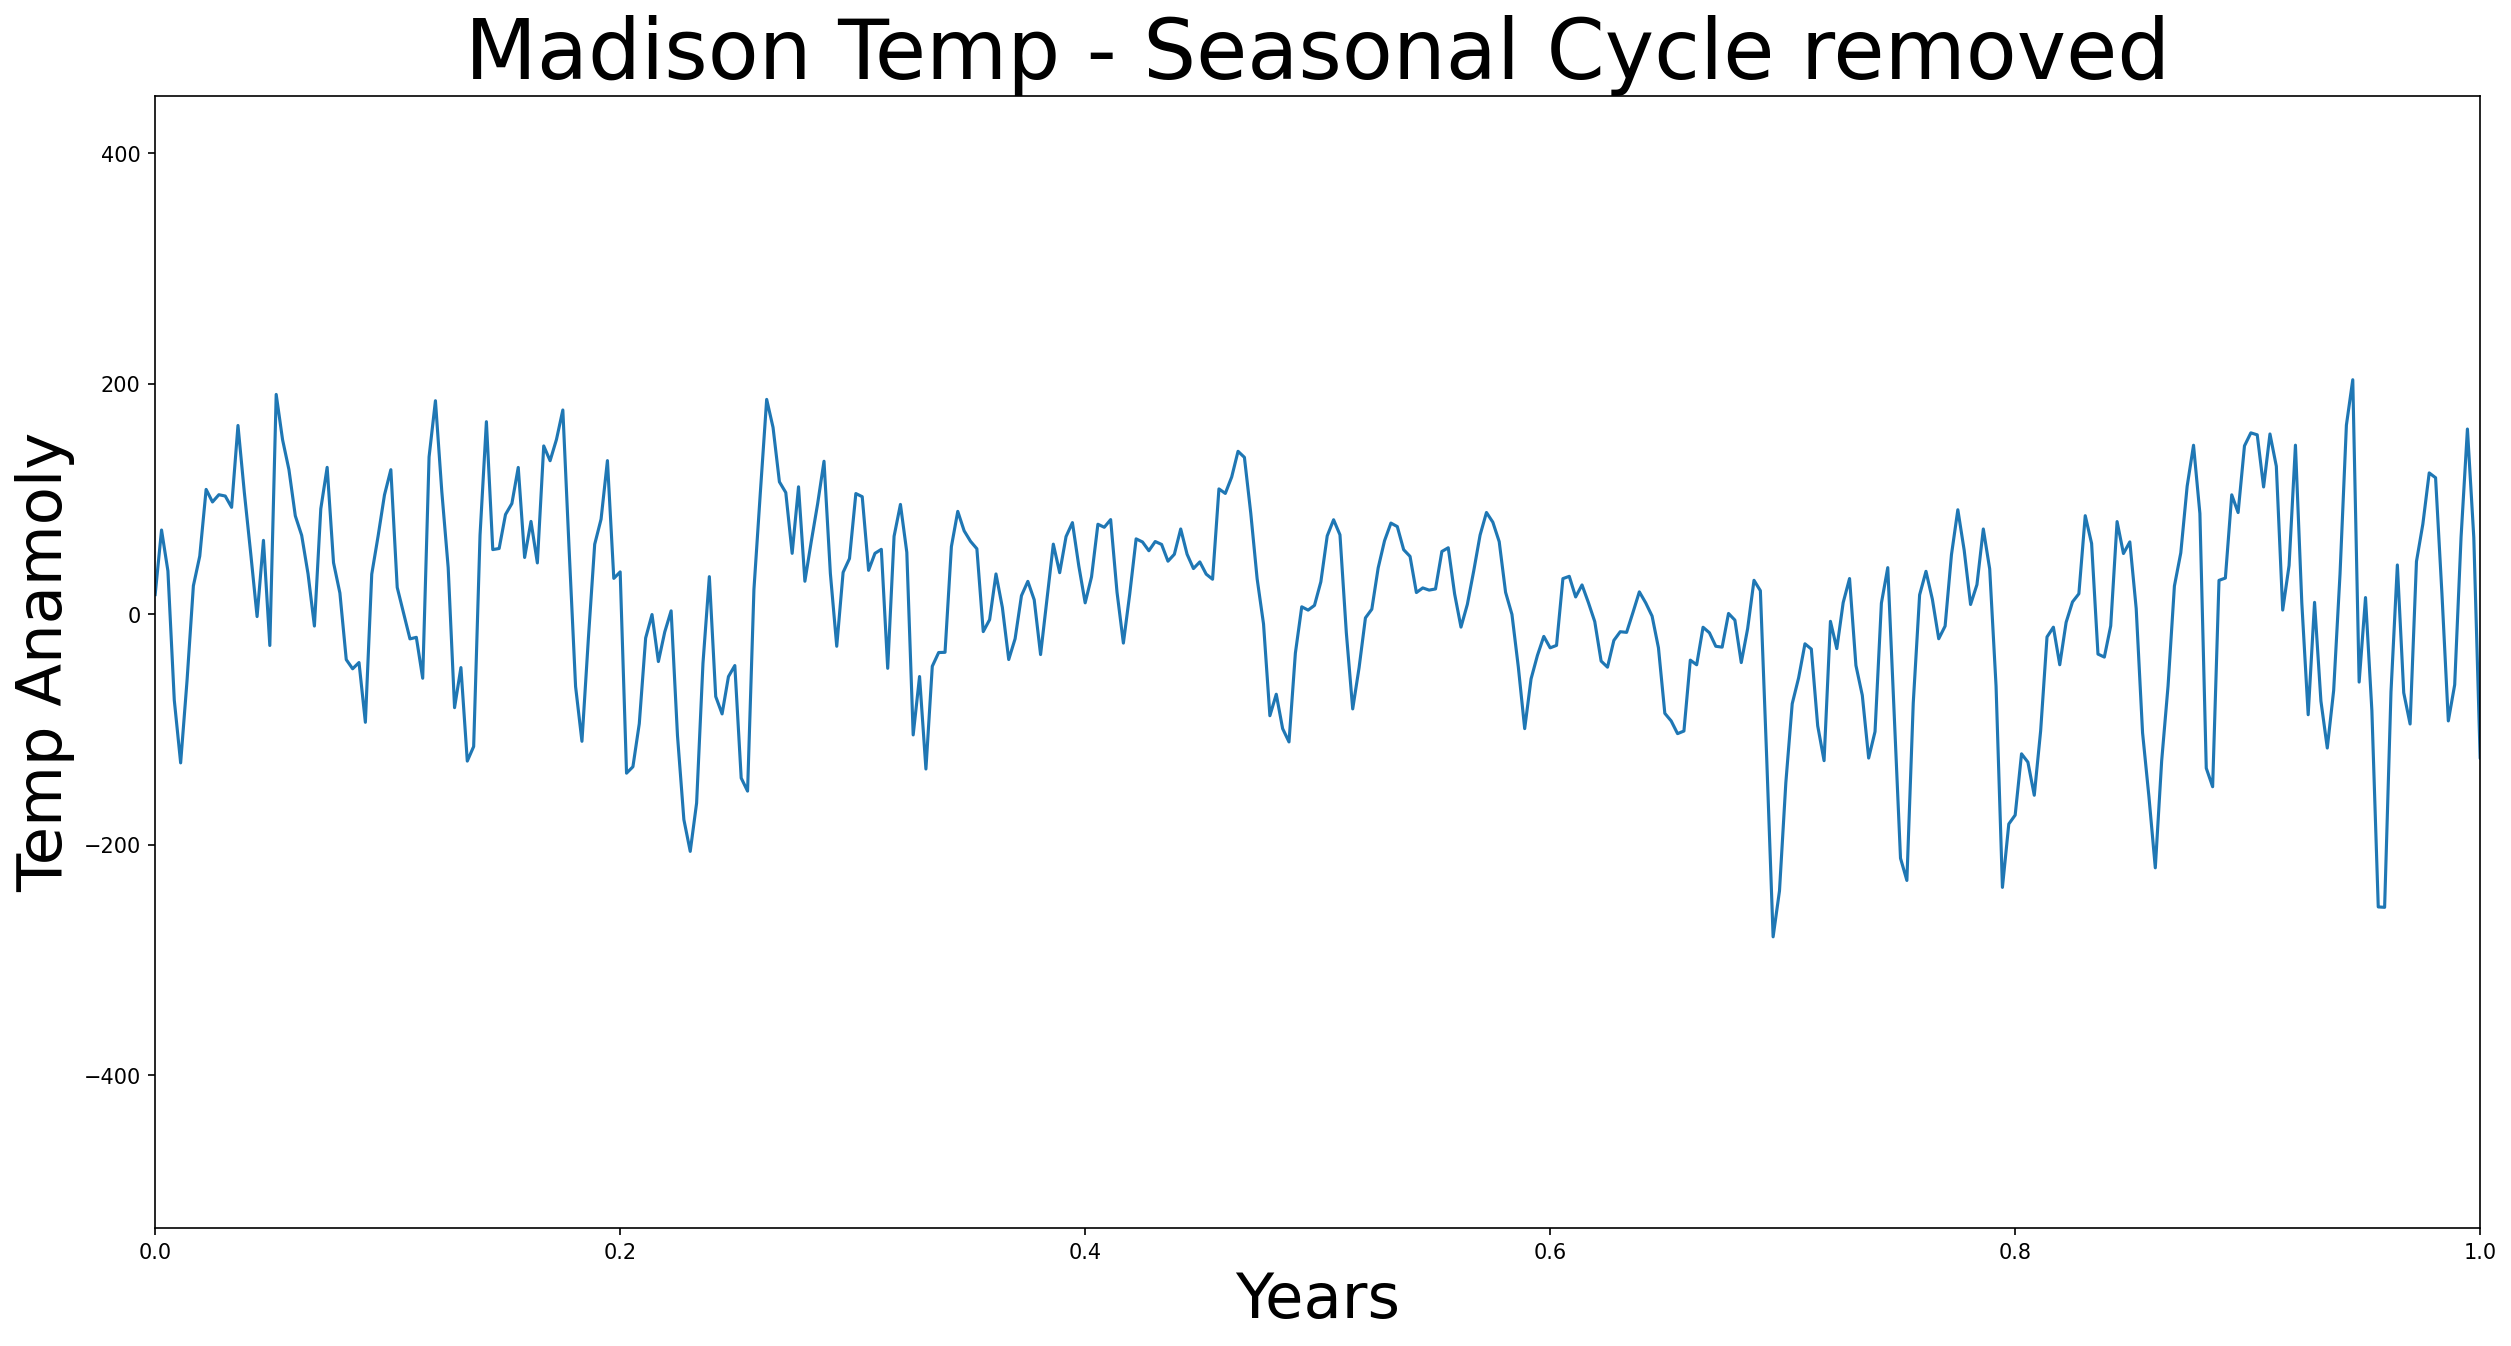

ic| years_train: array([1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810,
                        1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821,
                        1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832,
                        1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843,
                        1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854,
                        1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865,
                        1866, 1867, 1868, 1869])
ic| years_val: array([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880,
                      1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,
                      1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902,
                      1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913,
                      1914, 1915, 1916, 1917, 1918, 1919])


raw_data        = (73000, 96, 161, 1)
training data   = (25550, 96, 161, 1), (25550,)
validation data = (18250, 96, 161, 1), (18250,)
test data       = (29200, 96, 161, 1), (29200,)
X_mean          = -0.12288706758834869
X_std           = 94.02639887487958


In [8]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR = settings['data_dir']

if(EXP_NAME[:3]=='mjo'):

    labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )        
elif(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )

elif((EXP_NAME[:12]=='initial_test') or (EXP_NAME[:12]=='smaller_test') or (EXP_NAME[:13]=='balanced_test') or (EXP_NAME[:13]=='threeday_test') or (EXP_NAME[:12]=='zeroday_test') or (EXP_NAME[:16]=='fourteenday_test') or (EXP_NAME[:14]=='thirtyday_test')):

    labels, data, lat, lon, time = data_functions.load_pres_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_pres_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )

In [14]:
proto_class_mask = network.createClassIdentity(PROTOTYPES_PER_CLASS)

prototypes_of_correct_class_train = np.zeros((len(y_train),NPROTOTYPES))
for i in range(0,prototypes_of_correct_class_train.shape[0]):
    prototypes_of_correct_class_train[i,:] = proto_class_mask[:,int(y_train[i])]
    
prototypes_of_correct_class_val   = np.zeros((len(y_val),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_val.shape[0]):
    prototypes_of_correct_class_val[i,:] = proto_class_mask[:,int(y_val[i])]

prototypes_of_correct_class_test   = np.zeros((len(y_test),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_test.shape[0]):
    prototypes_of_correct_class_test[i,:] = proto_class_mask[:,int(y_test[i])]
    

## Define the training callbacks and metrics

In [15]:
# callbacks
def scheduler(epoch, lr):
    if epoch < LR_CALLBACK_EPOCH:
        return np.round(lr,8)
    else:
        if(epoch % 2 == 0):
            return lr/2.
        else:
            return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)    
    
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', 
    mode='max',
    patience=settings['patience'], 
    restore_best_weights=True, 
    verbose=1
)

callbacks_list = [
#     lr_callback,
#     es_callback,
]            

# metrics
metrics_list = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
]

## Instantiate the model

In [16]:
__ = imp.reload(network)
tf.keras.backend.clear_session()

model = network.build_model(
    nlayers              = NLAYERS,
    nfilters             = NFILTERS,
    input_shape          = X_train.shape[1:],
    output_shape         = NCLASSES,
    prototypes_per_class = PROTOTYPES_PER_CLASS,
    network_seed         = RANDOM_SEED,    
    prototype_channels   = settings['prototype_channels'],    
    coeff_cluster        = settings['coeff_cluster'],
    coeff_separation     = settings['coeff_separation'],
    coeff_l1             = settings['coeff_l1'],
    incorrect_strength   = settings['incorrect_strength'],
    double_conv          = settings['double_conv'],
    kernel_l1_coeff      = 0.0,#settings['kernel_l1_coeff'],
    kernel_l2_coeff      = 0.0,#settings['kernel_l2_coeff'],
    drop_rate            = 0.0,
    drop_rate_final      = 0.0,        
    
)
model.summary()

3
[16, 16, 16]
(96, 161, 1)
3
[10, 10, 10]
30
False
0.2
-0.02
0.1
-0.5
False
8
64
0.0
0.0
0.0
0.0
False
Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 96, 161, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_0 (Conv2D)                (None, 96, 161, 16)  160         ['inputs[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 96, 161, 16)  0           ['conv_0[0][0]']                 
                                                                                    

## Load pre-trained weights into convolutional layers

In [17]:
if(settings['pretrain'] == True):

    if(settings['pretrain_exp'] is None):
        PRETRAINED_MODEL = model_dir + 'pretrained_model_' + EXP_NAME 
    else:
        PRETRAINED_MODEL = './saved_models/' + settings['pretrain_exp'] 

    print('loading pretrained convolutional layers from ' + PRETRAINED_MODEL)
    pretrained_model = tf.keras.models.load_model(PRETRAINED_MODEL)

    for layer in range(1,len(model.layers)):
        if(model.layers[layer].name[:4]=='conv'):
            print('   loading pretrained weights for --> ' + model.layers[layer].name)
            model.layers[layer].set_weights(pretrained_model.layers[layer].get_weights())
else:
    print('no pretrained model specified. keeping random initialized weights.')
    

loading pretrained convolutional layers from ./saved_models/fourteenday_test/pretrained_model_fourteenday_test
   loading pretrained weights for --> conv_0
   loading pretrained weights for --> conv_1
   loading pretrained weights for --> conv_2


In [18]:
# raise ValueError('here')

***

# Run Training Stages

In [19]:
imp.reload(network)
imp.reload(plots)
imp.reload(push_prototypes)
imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

In [20]:
ic(np.shape(X_train))
ic(np.shape(prototypes_of_correct_class_train))
ic(np.shape(prototypes_of_correct_class_train))

ic| np.shape(X_train): (25550, 96, 161, 1)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)


(25550, 30)

In [21]:
imp.reload(push_prototypes)
NEPOCHS    = settings['nepochs']
STAGE_LIST = (0,1,2,3,4,5,6,7,8,9)#range(len(NEPOCHS))#(1,2,3,4,5)#range(len(NEPOCHS))

for stage in STAGE_LIST:
    
    print('--------------------')
    print('TRAINING STAGE = ' + str(stage))
    print('--------------------')

    # load previously trained stage, unless it is the 0th stage
    if(stage != 0):
        tf.keras.backend.clear_session()
        model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage-1)
#         model = common_functions.load_model(model_filename)
        model.load_weights(model_filename)
        
    # learn layers (during even numbered stages)
    if(stage % 2 == 0):
        # train prototypes layers (and possibly CNN layers)
        if(settings['pretrain']==False and settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(settings['train_cnn_in_stage'] == False or stage==0):
            model = network.set_trainable_layers(model, [False,True,True,False])
        elif(settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(stage >= settings['train_cnn_in_stage']):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        else:
            model = network.set_trainable_layers(model, [False,True,True,False])
    else:
        #.......................................................
        # push the prototypes
        #.......................................................        
        model, push_info = push_prototypes.push(model, 
                                                [X_train,prototypes_of_correct_class_train], 
                                                prototypes_of_correct_class_train, 
                                                perform_push=True,
                                                batch_size=BATCH_SIZE_PREDICT,
                                                verbose=False,
                                               )        
        print('Push complete.\n')            

        # train weights layer only
        model = network.set_trainable_layers(model, [False,False,False,True])        

    #.......................................................
    # compile the model
    #.......................................................
    if(stage>=settings['cut_lr_stage']):
        lr_factor = 10.**(np.floor((stage-settings['cut_lr_stage']+2)/2))
    else:
        lr_factor = 1.
    if(LR_INIT/lr_factor<settings['min_lr']):
        lr_factor = LR_INIT/settings['min_lr']
    print('learning rate = ' + str(np.asarray(LR_INIT/lr_factor,dtype='float32')))

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=np.asarray(LR_INIT/lr_factor,dtype='float32'), 
        ),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics = metrics_list,
    )
#     model.summary()
    ic(np.min(model.layers[-3].get_weights()[1]),np.max(model.layers[-3].get_weights()[1]))

    #.......................................................
    # train the model
    #.......................................................
    print('Training the model...')    
    
    tf.random.set_seed(RANDOM_SEED)   
    np.random.seed(RANDOM_SEED)    
    history = model.fit(
        [X_train,prototypes_of_correct_class_train],
        y_train,
        validation_data=([[X_val,prototypes_of_correct_class_val]], [y_val]),
        batch_size=BATCH_SIZE,
        epochs=NEPOCHS[stage],
        shuffle=True,
        verbose=1,
        callbacks=callbacks_list
    )
    print('Training complete.\n')            
        

    # save the model at this training stage
    model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage)
    common_functions.save_model(model, model_filename) 
    
    #.......................................................
    # plot results
    #.......................................................  
    try:
        # plot loss history of the model
        plots.plot_loss_history(history)
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_loss_history_stage' + str(stage) + '.png', dpi=dpiFig)    
        plt.close()

        # plot the weights
        plots.plot_weights(model, PROTOTYPES_PER_CLASS)    
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_weights_stage' + str(stage) + '.png', dpi=dpiFig)
        plt.close()
    except:
        print('not making plots...')
        plt.close()

ic| np.min(model.layers[-3].get_weights()[1]): 0.0
    np.max(model.layers[-3].get_weights()[1]): 0.0


--------------------
TRAINING STAGE = 0
--------------------
   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 53s 65ms/step - loss: 4.2219 - sparse_categorical_accuracy: 0.3413 - cluster_cost: 0.5108 - separation_cost: 0.4386 - l1_weights_cost: 3.0000 - val_loss: 4.1839 - val_sparse_categorical_accuracy: 0.3339 - val_cluster_cost: 0.2966 - val_separation_cost: 0.2695 - val_l1_weights_cost: 3.0000
Epoch 2/10
799/799 [==============================] - 45s 56ms/step - loss: 4.1820 - sparse_categorical_accuracy: 0.3420 - cluster_cost: 0.2900 - separation_cost: 0.2635 - l1_weights_cost: 3.0000 - val_loss: 4.1680 - val_sparse_categorical_accuracy: 0.3355 - val_cluster_cost: 0.2475 - val_separation_cost: 0.2

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage0/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage0/assets


--------------------
TRAINING STAGE = 1
--------------------
Running Prototype Push


2022-08-22 10:53:40.114552: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage0: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage0; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 5s 478ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01


ic| np.min(model.layers[-3].get_weights()[1]): -0.60984606
    np.max(model.layers[-3].get_weights()[1]): 1.840825


Training the model...
Epoch 1/10
799/799 [==============================] - 45s 55ms/step - loss: 7.5154 - sparse_categorical_accuracy: 0.3402 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.7092 - val_loss: 1.8323 - val_sparse_categorical_accuracy: 0.3298 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0588
Epoch 2/10
799/799 [==============================] - 37s 47ms/step - loss: 1.3894 - sparse_categorical_accuracy: 0.3400 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0357 - val_loss: 1.1920 - val_sparse_categorical_accuracy: 0.3354 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0224
Epoch 3/10
799/799 [==============================] - 37s 46ms/step - loss: 1.3034 - sparse_categorical_accuracy: 0.3395 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0226 - val_loss: 1.2706 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage1/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage1/assets
2022-08-22 11:00:32.258669: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage1: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -0.60984606
    np.max(model.layers[-3].get_weights()[1]): 1.840825


--------------------
TRAINING STAGE = 2
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 114s 141ms/step - loss: 1.1268 - sparse_categorical_accuracy: 0.3406 - cluster_cost: 0.0312 - separation_cost: 0.0190 - l1_weights_cost: 0.0221 - val_loss: 1.1216 - val_sparse_categorical_accuracy: 0.3386 - val_cluster_cost: 0.0069 - val_separation_cost: 0.0033 - val_l1_weights_cost: 0.0221
Epoch 2/10
799/799 [==============================] - 101s 127ms/step - loss: 1.1239 - sparse_categorical_accuracy: 0.3488 - cluster_cost: 0.0213 - separation_cost: 0.0104 - l1_weights_cost: 0.0221 - val_loss: 1.1257 - val_sparse_categorical_accuracy: 0.3396 - val_cluster_cost: 0.0256 - val_separation_cost: 0.013

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage2/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage2/assets


--------------------
TRAINING STAGE = 3
--------------------
Running Prototype Push


2022-08-22 11:17:46.230999: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage2: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage2; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 439ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01


ic| np.min(model.layers[-3].get_weights()[1]): -1.2584842
    np.max(model.layers[-3].get_weights()[1]): 4.0213013


Training the model...
Epoch 1/10
799/799 [==============================] - 42s 51ms/step - loss: 3.3681 - sparse_categorical_accuracy: 0.3442 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0252 - val_loss: 2.2422 - val_sparse_categorical_accuracy: 0.3356 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0200
Epoch 2/10
799/799 [==============================] - 35s 43ms/step - loss: 3.1490 - sparse_categorical_accuracy: 0.3429 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0185 - val_loss: 2.2007 - val_sparse_categorical_accuracy: 0.3235 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0169
Epoch 3/10
799/799 [==============================] - 35s 44ms/step - loss: 2.8902 - sparse_categorical_accuracy: 0.3423 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0168 - val_loss: 2.5067 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage3/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage3/assets
2022-08-22 11:24:12.947299: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage3: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage3; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.2584842
    np.max(model.layers[-3].get_weights()[1]): 4.0213013


--------------------
TRAINING STAGE = 4
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.001
Training the model...
Epoch 1/10
799/799 [==============================] - 104s 129ms/step - loss: 1.1669 - sparse_categorical_accuracy: 0.3506 - cluster_cost: 0.0021 - separation_cost: 2.6241e-04 - l1_weights_cost: 0.0233 - val_loss: 1.1344 - val_sparse_categorical_accuracy: 0.3513 - val_cluster_cost: 0.0038 - val_separation_cost: 5.5541e-04 - val_l1_weights_cost: 0.0233
Epoch 2/10
799/799 [==============================] - 100s 125ms/step - loss: 1.1211 - sparse_categorical_accuracy: 0.3677 - cluster_cost: 0.0045 - separation_cost: 9.2377e-04 - l1_weights_cost: 0.0233 - val_loss: 1.1264 - val_sparse_categorical_accuracy: 0.3494 - val_cluster_cost: 0.0049 - val_separatio

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage4/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage4/assets


--------------------
TRAINING STAGE = 5
--------------------
Running Prototype Push


2022-08-22 11:41:08.766327: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage4: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage4; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 5s 483ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.001


ic| np.min(model.layers[-3].get_weights()[1]): -1.2584842
    np.max(model.layers[-3].get_weights()[1]): 3.9089959


Training the model...
Epoch 1/10
799/799 [==============================] - 46s 56ms/step - loss: 1.2234 - sparse_categorical_accuracy: 0.3488 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0062 - val_loss: 1.2608 - val_sparse_categorical_accuracy: 0.3326 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0043
Epoch 2/10
799/799 [==============================] - 37s 46ms/step - loss: 1.2107 - sparse_categorical_accuracy: 0.3539 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0041 - val_loss: 1.1262 - val_sparse_categorical_accuracy: 0.3461 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0039
Epoch 3/10
799/799 [==============================] - 37s 46ms/step - loss: 1.2215 - sparse_categorical_accuracy: 0.3514 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0040 - val_loss: 1.1293 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage5/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage5/assets
2022-08-22 11:48:07.545790: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage5: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage5; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.2584842
    np.max(model.layers[-3].get_weights()[1]): 3.9089959


--------------------
TRAINING STAGE = 6
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-04
Training the model...
Epoch 1/10
799/799 [==============================] - 112s 138ms/step - loss: 1.1054 - sparse_categorical_accuracy: 0.3575 - cluster_cost: 6.2969e-05 - separation_cost: 7.2679e-06 - l1_weights_cost: 0.0048 - val_loss: 1.1096 - val_sparse_categorical_accuracy: 0.3515 - val_cluster_cost: 2.3975e-04 - val_separation_cost: 4.4173e-05 - val_l1_weights_cost: 0.0048
Epoch 2/10
799/799 [==============================] - 102s 128ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.3710 - cluster_cost: 3.2751e-04 - separation_cost: 1.6342e-04 - l1_weights_cost: 0.0048 - val_loss: 1.1063 - val_sparse_categorical_accuracy: 0.3500 - val_cluster_cost: 5.5589e-04

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage6/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage6/assets


--------------------
TRAINING STAGE = 7
--------------------
Running Prototype Push


2022-08-22 12:05:14.987700: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage6: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage6; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 5s 464ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-04


ic| np.min(model.layers[-3].get_weights()[1]): -1.2584842
    np.max(model.layers[-3].get_weights()[1]): 3.8001707


Training the model...
Epoch 1/10
799/799 [==============================] - 46s 56ms/step - loss: 1.1064 - sparse_categorical_accuracy: 0.3584 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0023 - val_loss: 1.1020 - val_sparse_categorical_accuracy: 0.3563 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0017
Epoch 2/10
799/799 [==============================] - 36s 45ms/step - loss: 1.1056 - sparse_categorical_accuracy: 0.3622 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0016 - val_loss: 1.1409 - val_sparse_categorical_accuracy: 0.3356 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0016
Epoch 3/10
799/799 [==============================] - 36s 45ms/step - loss: 1.1073 - sparse_categorical_accuracy: 0.3642 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0015 - val_loss: 1.1263 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage7/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage7/assets
2022-08-22 12:12:00.073322: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage7: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage7; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.2584842
    np.max(model.layers[-3].get_weights()[1]): 3.8001707


--------------------
TRAINING STAGE = 8
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-05
Training the model...
Epoch 1/10
799/799 [==============================] - 109s 136ms/step - loss: 1.0936 - sparse_categorical_accuracy: 0.3664 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0014 - val_loss: 1.1027 - val_sparse_categorical_accuracy: 0.3512 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0014
Epoch 2/10
799/799 [==============================] - 99s 124ms/step - loss: 1.0907 - sparse_categorical_accuracy: 0.3778 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0014 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.3511 - val_cluster_cost: 0.0000e+00 

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage8/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage8/assets


--------------------
TRAINING STAGE = 9
--------------------
Running Prototype Push


2022-08-22 12:28:48.583576: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fourteenday_test/model_fourteenday_test_stage8: FAILED_PRECONDITION: saved_models/fourteenday_test/model_fourteenday_test_stage8; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 5s 478ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-05


ic| np.min(model.layers[-3].get_weights()[1]): -1.2584842
    np.max(model.layers[-3].get_weights()[1]): 3.791676


Training the model...
Epoch 1/10
799/799 [==============================] - 45s 55ms/step - loss: 1.0901 - sparse_categorical_accuracy: 0.3685 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0011 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.3547 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 9.1791e-04
Epoch 2/10
799/799 [==============================] - 36s 45ms/step - loss: 1.0901 - sparse_categorical_accuracy: 0.3810 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 9.1197e-04 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.3514 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 8.2010e-04
Epoch 3/10
799/799 [==============================] - 35s 44ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.3762 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 8.4937e-04 - val_loss: 1.0989 - val_sparse_catego

INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage9/assets


INFO:tensorflow:Assets written to: ./saved_models/fourteenday_test/model_fourteenday_test_stage9/assets
